The goal of this project is to build a **Classification Tree** to predict whether or not an individual is obese.

We use the **[Estimation of Obesity Levels Based On Eating Habits and Physical Condition](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)** dataset from the UCI Machine Learning Repository.

# Import Modules

In [1]:
# Import pandas for data handling
import pandas as pd

# Import numpy for numerical operations
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import scikit-learn for decision tree and model evaluation tools
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import balanced_accuracy_score

----

# Load the Dataset

In [2]:
# Fetch dataset as pandas dataframe
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


This data contains the following variables:
Variable | Description
-- | --
Gender |
Age |
Height |
Weight |
family_history_with_overweight | Has a family member suffered or suffers from overweight?
FAVC | Do you eat high caloric food frequently?
FCVC | Do you usually eat vegetables in your meals
NCP | How many main meals do you have daily?
CAEC | Do you eat any food between meals?
SMOKE | Do you smoke?
CH2O | How much water do you drink daily?
SCC | Do you monitor the calories you eat daily?
FAF | How often do you have physical activity?
TUE | How much time do you use technological devices?
CALC | How often do you drink alcohol?
MTRANS | Which transportation do you usually use?
NObeyesdad | Obesity level

<div style="page-break-before: always;"></div>

# Identify Missing Data

First, we want to check if the dataset contains any missing values.

In [3]:
# Print data type of each column
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

We can see that some columns have `object` data type, which can potentially include missing values. 

In [4]:
# Print unique values of column with 'object' data type
for col in df.select_dtypes(include='object').columns:
    print(col, ": ", df[col].unique())

Gender :  ['Female' 'Male']
family_history_with_overweight :  ['yes' 'no']
FAVC :  ['no' 'yes']
CAEC :  ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE :  ['no' 'yes']
SCC :  ['no' 'yes']
CALC :  ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS :  ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
NObeyesdad :  ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Since there are no values indicating missing data such as `NaN`, we can proceed to the next step.

<div style="page-break-before: always;"></div>

# Format the Data for Decision Trees

First, we split our dataset into the following:
- `X`: data of **feature variables**, which we will use to predict classifications.

- `y`: data of **target variable**, which is obesity level stored in the `NObeyesdad` column.

In [5]:
# Split data into X and y (use copy to preserve the original data)
X = df.drop('NObeyesdad', axis=1).copy()
y = df['NObeyesdad'].copy()

Now, we observe that our feature variables can be divided into two categories:
- **Physical attributes**: `Gender`, `Age`, `Height`, `Weight`

- **Daily habits**: `family_history_with_overweight`, `FAVC`, `FCVC`, `NCP`, `CAEC`, `SMOKE`, `CH2O`, `SCC`, `FAF`, `TUE`, `CALC`, `MTRANS`  

Since physical attributes are likely too directly linked to obesity, we decide to omit these variables. 

Instead, we aim to estimate obesity based solely on daily habits.

In [6]:
# Drop physical features
X = X.drop(columns=['Gender', 'Age', 'Height', 'Weight'])

Next, we can categorize the remaining feature variables as follows:
- **Quantitative**: `FCVC`, `NCP`, `CH2O`, `FAF`, `TUE`
- **Categorical**: 

  - **Ordinal**: `family_history_with_overweight`, `FAVC`, `SMOKE`, `SCC`, `CAEC`, `CALC`

  - **Nominal**: `MTRANS`    

To prepare the data for building a decision tree, we map **ordinal** variables to numerical values and apply *one-hot encoding* to **nominal** variables.

In [7]:
# Silence the warning for replace()
pd.set_option('future.no_silent_downcasting', True)

# Replace (yes, no) with (1, 0)
X = X.replace({'yes': 1, 'no': 0})

# Replace (no, Sometimes, Frequently, Always) with (0, 1, 2, 3)
X = X.replace({'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# Apply one-hot encoding to 'MTRANS'
X = pd.get_dummies(X, columns=['MTRANS'])

X.head()

,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,False,False,False,True,False
1,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,False,False,False,True,False
2,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,False,False,False,True,False
3,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,False,False,False,False,True
4,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,False,False,False,True,False


For `y`, we simplify the problem to a **binary classification**. We define the categories as:
- `0` (Not Obese): *Insufficient_Weight*, *Normal_Weight*, *Overweight_Level_I*, *Overweight_Level_II*

- `1` (Obese): *Obesity_Type_I*, *Obesity_Type_II*, *Obesity_Type_III*

In [8]:
# Classify y as binary
y.loc[y.str.startswith('Obesity')] = 1
y.loc[y != 1] = 0
y = y.astype(int)

y.unique()

array([0, 1])

<div style="page-break-before: always;"></div>

# Build a Preliminary Classification Tree

To begin with, we split our data into **training** dataset and **testing** dataset.

Then, we use the training set to build the decision tree.

To evaluate performance, we use **balanced accuracy**, which takes into account the accuracy on each class equally.

Balanced Accuracy on Training Dataset: 1.0
Balanced Accuracy on Testing Dataset: 0.8428070175438597


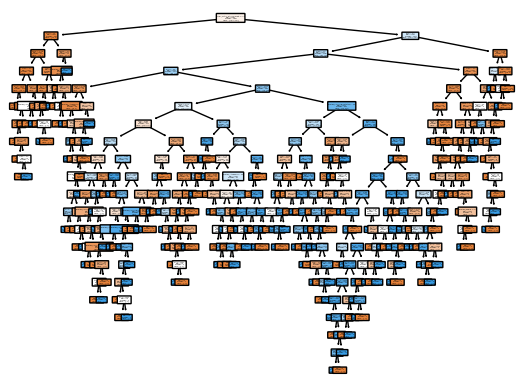

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a decision tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

# Plot the tree
plot_tree(clf_dt, 
          filled=True, 
          rounded=True,
          class_names=["Not Obese", "Obese"], 
          feature_names=X.columns)

# Compute balanced accuracy for training and testing dataset 
print("Balanced Accuracy on Training Dataset:", balanced_accuracy_score(y_train, clf_dt.predict(X_train)))
print("Balanced Accuracy on Testing Dataset:", balanced_accuracy_score(y_test, clf_dt.predict(X_test)))

### Observations:
- We have constructed a **classification tree** with high accuracy on both the training and testing datasets.

- However, since the accuracy on training dataset is significantly higher (≈100%), this indicates that our model is **overfitting**.

- Additionally, the tree appears to be too large and complex.

To address this, we now aim to simplify the tree while maintaining its accuracy.

<div style="page-break-before: always;"></div>

# Apply Cost Complexity Pruning

As the next step, we apply **Cost Complexity Pruning** to reduce the tree size.

The pruning parameter `α` controls the penalty for adding more leaves to the tree.  

A higher `α` results in a smaller tree, but can potentially lead to underfitting.

Our goal is to find the optimal value of `α`.

In [10]:
# Extract different values for α
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) 
ccp_alphas = path.ccp_alphas 

# Create one decision tree per value for α
clf_dts = [] 
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

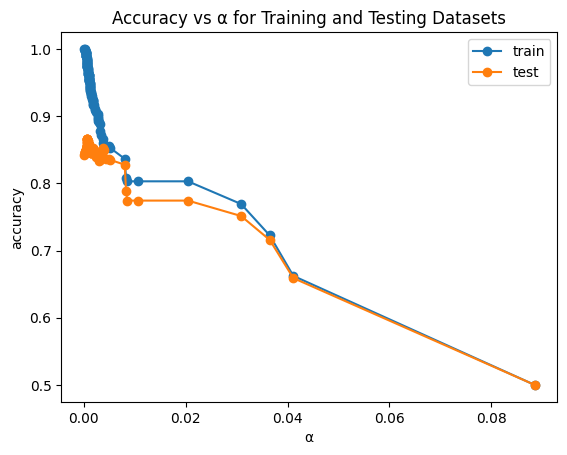

In [11]:
# Compute accuracy for training and testing dataset 
train_scores = []
test_scores = []
for clf_dt in clf_dts:
    train_scores.append(balanced_accuracy_score(y_train, clf_dt.predict(X_train)))
    test_scores.append(balanced_accuracy_score(y_test, clf_dt.predict(X_test)))

# Plot accuracy vs alpha
plt.plot(ccp_alphas, train_scores, marker='o', label="train")
plt.plot(ccp_alphas, test_scores, marker='o', label="test")
plt.xlabel("α")
plt.ylabel("accuracy")
plt.title("Accuracy vs α for Training and Testing Datasets")
plt.legend()
plt.show()

### Observations:
- The maximum accuracy occurs at a very small value of `α`.

- After this point, both training and testing accuracy decrease and gradually converge.

- An *elbow point* is observed at `α ≈ 0.02`, where the accuracy remains stable for a while, then starts to decline more sharply.

We decide to pick `α ≈ 0.02` to be our potential optimal `α` even though it results in a slight accuracy loss compared to the previous model.

This is a **trade-off** of accepting a small loss in accuracy in exchange for a simpler, more interpretable tree and reduced overfitting.

<div style="page-break-before: always;"></div>

# Perform Cross Validation

One concern now is that our optimal `α` can be subjective to the specific split of training and testing dataset.

To investigate this, we use **10-fold Cross Validation** to demonstrate how different splits can result in varying accuracy for `α = 0.02`.

<Axes: title={'center': 'Accuracy for Different Training/Testing Split'}, xlabel='model'>

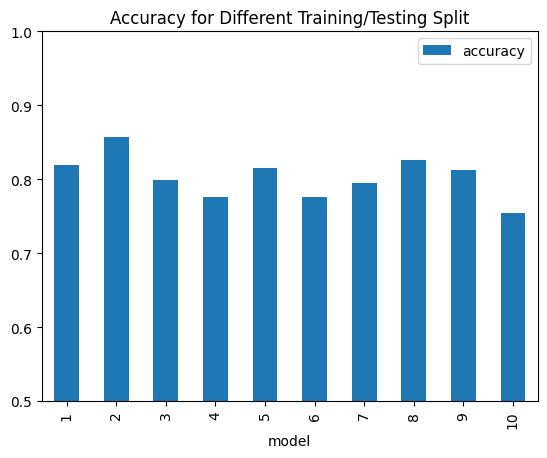

In [16]:
# Create the tree with alpha = 0.02
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.02) 

# Perform 10-fold cross validation 
scores = cross_val_score(clf_dt, X_train, y_train, cv=10, scoring='balanced_accuracy') 

# Plot accuracy vs model
df = pd.DataFrame(data={'model': range(1,11), 'accuracy': scores})
df.plot.bar(x='model', y='accuracy', ylim=(0.5,1), title="Accuracy for Different Training/Testing Split")

We can verify that accuracy varies depending on the training/testing split.

To account for this variability, we calculate the **mean accuracy** across the 10 models (from 10-fold Cross Validation) for each value of `α`.
<div style="page-break-before: always;"></div>

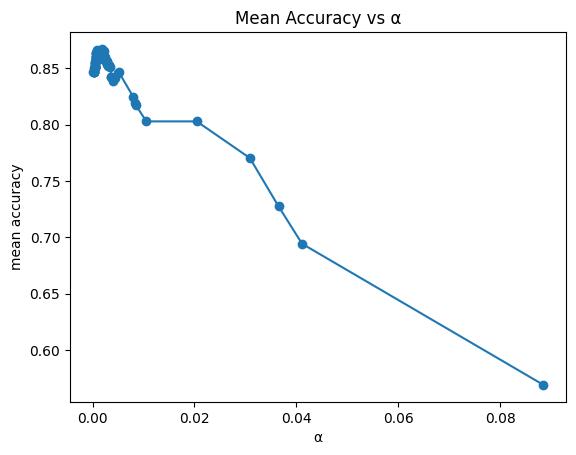

In [13]:
# Perform cross validation for each α
mean_accuracy = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=10, scoring='balanced_accuracy')
    # Compute mean accuracy
    mean_accuracy.append(np.mean(scores))
    
# Plot mean accuracy vs alpha
plt.plot(ccp_alphas,mean_accuracy,marker='o')
plt.xlabel("α")
plt.ylabel("mean accuracy")
plt.title("Mean Accuracy vs α")
plt.show()

Here, we observe a similar pattern in the mean accuracy.

Therefore, we conclude that the elbow point at `α ≈ 0.02` is a reliable choice for our optimal `α`.

In [14]:
# Extract the optimal α
ccp_alpha_opt = ccp_alphas[(ccp_alphas > 0.02)][0]

print("Optimal α:", ccp_alpha_opt)

Optimal α: 0.02044896579510605


<div style="page-break-before: always;"></div>

# Build and Interpret the Final Classification Tree

With our optimal `α` identified, we now build the final classification tree.

Balanced Accuracy on Training Dataset: 0.8029816601945481
Balanced Accuracy on Testing Dataset: 0.774298245614035


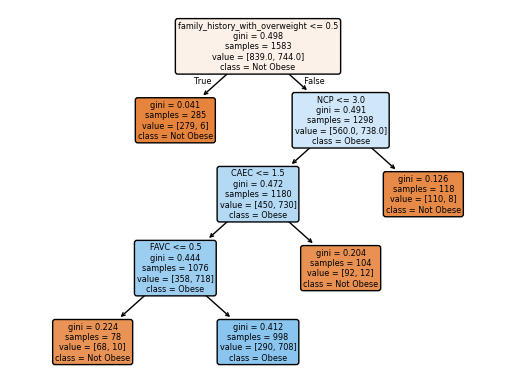

In [15]:
# Build tree with optimal α
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha_opt)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 

# Plot the tree
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True,
          class_names=["Not Obese", "Obese"], 
          feature_names=X.columns)

# Compute the balanced accuracy
print("Balanced Accuracy on Training Dataset:", balanced_accuracy_score(y_train, clf_dt_pruned.predict(X_train)))
print("Balanced Accuracy on Testing Dataset:", balanced_accuracy_score(y_test, clf_dt_pruned.predict(X_test)))

### Interpretation: 
We can interpret the decision path for predicting obesity in this tree as follows:  
1. Has a family member suffered or suffers from overweight? (*family_history_with_overweight <= 0.5*)  

    Yes -> Go to Step `2`  

    No -> `Not Obese`

2. How many main meals do you have daily? (*NCP <= 3.0*)  

    More than 3.0 -> `Not Obese`
    
    Otherwise -> Go to Step `3`

3. Do you eat any food between meals? (*CAEC <= 1.5*)  

    (No, Sometimes) -> Go to Step `4`  

    (Frequently, Always) -> `Not Obese`

4. Do you eat high caloric food frequently? (*FAVC <= 0.5*)  

    Yes -> `Obese`
    
    No -> `Not Obese`
<div style="page-break-before: always;"></div>

### Observations:
- We were able to build a much more concise and interpretable tree with relatively high accuracy on both the training and testing datasets.

- The tree uses only four variables:
  - `family_history_with_overweight` (Has a family member suffered or suffers from overweight?)

  - `NCP` (How many main meals do you have daily?)

  - `CAEC` (Do you eat any food between meals?)

  - `FAVC` (Do you eat high caloric food frequently?)
  
- This highlights that **genetics** and **diet** are key factors in predicting obesity.

- Steps 2 and 3 yield somewhat unexpected results, suggesting that more frequent meals may contribute to a healthy weight.

<div style="page-break-before: always;"></div>

# Source
- StatQuest with Josh Starmer. (2020, June 6). *Classification Trees in Python from Start to Finish* [Video]. YouTube. https://youtu.be/q90UDEgYqeI
